In [ ]:
#submitted by : CS22MTECH02002

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import math

In [ ]:
#torch.manual_seed(1)
#np.random.seed(1)

In [78]:
epsilon = 0.0000000001 # this is defined to save any divission operation getting trapped in "divison by zero issue"

Q1) Perceptron learning algorithm
[10 = dataset creation 2 + perceptron learning algorithm 5 + analysis 3]
Implement perceptron learning algorithm for classifying a linearly separable dataset in 2D. Note
that you have to create such a dataset with at least 1000 data points.
Discuss your observations with respect to number of iterations required for perfect classification (k)
by varying the level of separability (γ from the class discussions) in the dataset. (Hint: compute
the average value of k for each level of γ, and do this for about 5 values of γ. Observe if you can
relate to the result discussed in class)

In [79]:
#augmenting 2 columns each for constant(x0, which will be combined with bias) and true label to each of the datasets
#a tensor will be returned whose last colun will always be true labels
def augment_class_data(X,true_label_function,non_linear_boundary=""):
  ''' for each class provide with actual label '''
  rows,columns=X.shape[0],X.shape[0]
  constant_col_tensor=torch.empty(rows,1).fill_(1)   
  if non_linear_boundary =="":    
    true_label_col_tensor=true_label_function(X)
  else:
    true_label_col_tensor=true_label_function(X,non_linear_boundary)    
  temp=torch.cat((constant_col_tensor,true_label_col_tensor),dim=1)
  return torch.cat((X,temp),dim=1)


In [80]:
# Define the linear function for the boundary
def linear_function(x1,x2):
  return 2*x1-x2+1

In [81]:
# Define the non-linear function for the boundary

def circle_non_linear_function(x1, x2):
    return x1**2 + x2**2 - 2
def parabola_non_linear_function(x1, x2):
    return x1**2 - 4*0.5*x2
def ellipse_non_linear_function(x1, x2):
    return (x1**2)/6 + (x2**2)/4 - 0.9
def hyperbola_non_linear_function(x1, x2):
     return (x1**2)/8 - (x2**2)/6 - 0.1
def tanh_non_linear_function(x1, x2):
     return (x1**2)/8 - (x2**2)/6 - 0.1


In [82]:
# defined by the user as per the need 
def linear_true_labels_1(X):
  rows=X.shape[0]
  half=rows/2
  y = np.array([1 if i<half else -1 for i in range(rows)])
  return torch.from_numpy(y).reshape(X.shape[0],1)


In [83]:
def non_linear_true_labels_1(X,non_linear_boundary):
  rows=X.shape[0]
  half=rows/2
  y = np.array([1 if non_linear_boundary(X[i,0],X[i,1]) > 0 else -1 for i in range(rows)])
  return torch.from_numpy(y).reshape(X.shape[0],1)

In [84]:
#Q1.a) 2-D Linearly Seperable Dataset Creation
#Method 1: Generation through only using gausssian distribution
def linear_seperable(mean1,std_dev1,mean2,std_dev2, num_samples,true_label_function):
  ''' for each dimension among x1,x2 the samples are taken from a dedicated gaussian distribution '''
  #do data type conversion
  mean1=float(mean1)
  std_dev1=float(std_dev1)
  mean2=float(mean2)
  std_dev2=float(std_dev2)

  # this arrangment(sampling a pair of values from 2 different multivariate distribution )
  x_1=torch.normal(mean1,std_dev1,size=(num_samples,2))
  x_2=torch.normal(mean2,std_dev2,size=(num_samples,2))
  X=torch.cat((x_1,x_2),dim=0)
  print("shape of final X is")
  print(X.shape)
  Xby=augment_class_data(X,true_label_function) # Xby conveys that this tensor contains 2-D input "X", followed by bias "b" , followed by "Y"
  return Xby


In [85]:
#Method 1: Generation through only using gausssian distribution with a min value of seperation guarenteed
def linear_seperable_guarented(mean1,std_dev1,mean2,std_dev2,num_samples,seperation=0.1):
  ''' for each dimension among x1,x2 the samples are taken from a dedicated gaussian distribution '''
  #do data type conversion
  mean1=float(mean1)
  std_dev1=float(std_dev1)
  mean2=float(mean2)
  std_dev2=float(std_dev2)
  params_vector=torch.normal(mean2,std_dev2,size=(1,3)) # a random hyperplane
  params_vector_norm=torch.norm(params_vector).item()
  # ------- For class "1" i.e np.dot(params_vector.T,sample)/torch.norm(params_vector)> some positive constant & class "-1" i.e np.dot(params_vector.T,sample)/torch.norm(params_vector)< some positive constant 
  x_1=torch.zeros(size=(1,4))
  x_2=torch.zeros(size=(1,4))  
  max_samples=10000000 
  const_tensor_1=torch.as_tensor(1).reshape(1,1)
  const_tensor_neg_1=torch.as_tensor(-1).reshape(1,1)
  
  for run in range(max_samples):        
    if x_1.shape[0]>=num_samples+1 and x_2.shape[0]>=num_samples+1:
      break
    sample=torch.normal(mean1,std_dev1,size=(1,2))
    sample=torch.cat((sample,const_tensor_1),dim=1)    
    dot=torch.dot(params_vector.T[:,0],sample[0,:]).item()
    perpend_distance=dot/params_vector_norm
    if dot >0 and perpend_distance >= seperation and x_1.shape[0] <=num_samples+1:
      sample=torch.cat((sample,const_tensor_1),dim=1)
      x_1=torch.cat((x_1,sample))
    elif dot <0 and perpend_distance <= -1.0*seperation and x_2.shape[0] <=num_samples+1:
      sample=torch.cat((sample,const_tensor_neg_1),dim=1)
      x_2=torch.cat((x_2,sample))       
    
  x_1=x_1[1:,:]
  x_2=x_2[1:,:]

  X=torch.cat((x_1,x_2),dim=0)
  
  return (X,params_vector)


In [86]:
#Method 2: geometrical method 

def non_linear_seperable(mean1,std_dev1,mean2,std_dev2, num_samples, true_label_function, shape="circle"):
  ''' Getting random samples from any gaussain family distribution and creating a well defined trajectory/topology from these random samples[points in space] using a deterministic function
 There are options for shapes that can be generated; below is the list:
 1)circle
 2)parabola
 3)hyperbola
 4)ellipse

 '''
  mean1=float(mean1)
  std_dev1=float(std_dev1)
  mean2=float(mean2)
  std_dev2=float(std_dev2)
  # Generate random points for the dataset
  # Generate the labels for the dataset
  non_linear_boundary=0
  if shape=="parabola":
    non_linear_boundary=parabola_non_linear_function
  elif shape=="hyperbola":
    non_linear_boundary=hyperbola_non_linear_function
  elif shape=="ellipse":
    non_linear_boundary=ellipse_non_linear_function
  else:
    non_linear_boundary=circle_non_linear_function

  max_iter=1000000000
  Rand_data_positive=torch.tensor([0.0,0.0,0.0,0.0],dtype=torch.float64).reshape(1,4)
  Rand_data_negative=torch.tensor([0.0,0.0,0.0,0.0],dtype=torch.float64).reshape(1,4)
  positive_class=0
  negative_class=0
  const_1=torch.as_tensor(1.0).reshape(1,1)
  const_neg_1=torch.as_tensor(-1.0).reshape(1,1)
  for iter in range(max_iter):
    Rand=torch.normal(mean1, std_dev1, size=(1,2))    
    temp=Rand
    if(positive_class>num_samples and negative_class>num_samples):
      break

    if non_linear_boundary(Rand[0,0],Rand[0,1])>=0.0 and positive_class<=num_samples:
            
      temp=torch.cat((temp,const_1),dim=1)
      temp=torch.cat((temp,const_1),dim=1)
      Rand_data_positive=torch.cat((Rand_data_positive,temp))
      positive_class+=1

    if non_linear_boundary(Rand[0,0],Rand[0,1])<0.0 and negative_class<=num_samples:
      
      temp=torch.cat((temp,const_1),dim=1)
      temp=torch.cat((temp,const_neg_1),dim=1)
      Rand_data_negative=torch.cat((Rand_data_negative,temp))
      negative_class+=1

  Rand_data=torch.cat((Rand_data_negative[1:,:],Rand_data_positive[1:,:]))  
  
  return Rand_data



In [88]:
def plot_data_and_hyperplane(Xby,color_map,class_distribution=0,params_vector=""):
  ''' first number of classes will be extracted out of y and then plotting will happen accordingly '''
  y=Xby[:,-1]
  classes={}
  for label in y:
    if str(label.item()) not in classes:
      classes[str(label.item())]=1
    else:
      classes[str(label.item())]+=1
  class_labels=list(classes.keys())
  class_frq=list(classes.values())
  
  if class_distribution==1:
    figure, axis = plt.subplots()

    # plotting histogram for class distribution
    axis.bar(class_labels,class_frq)
    axis.set_xlabel("class_labels")
    axis.set_ylabel("class_frequency")
    axis.set_title("distribution histogram")
   
  figure, axis = plt.subplots()
  color_labels=color_map.keys()
  for labels in class_labels:
    if labels in  color_labels:
      axis.scatter(Xby[y == float(labels)][:, 0], Xby[y == float(labels)][:, 1], color=color_map[labels], label="class"+labels)
    else:
      print("the class labels in color map and in data does not match")
      break 

  axis.set_title("Data set plot in 2-D Eucledian plane ")
  axis.set_xlabel("x_1")
  axis.set_ylabel("x_2")

  if params_vector != "":
    x_1_max=torch.max(Xby[:,1])
    x_1_min=torch.min(Xby[:,1])
    x_1 = np.linspace(x_1_min,x_1_max,500) # all the points on seperating hyperplane
    x_2=1
    try:
      x_2 = -(params_vector[0].item()/(params_vector[1].item()))*x_1 - (params_vector[2].item()/(params_vector[1].item()))
    except Exception as e:
      print("{} exception has occured ")
      x_2=[params_vector[2].item()]*x_1.shape[0]      
    axis.plot(x_1, x_2, '-r', label='seperating hyperplane')


Plotting 2D-Linearly Dataset

shape of final X is
torch.Size([3000, 2])


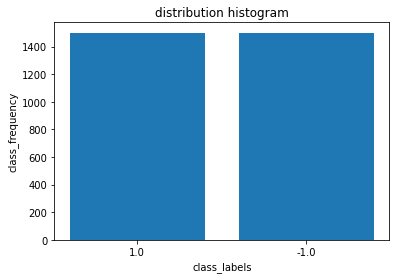

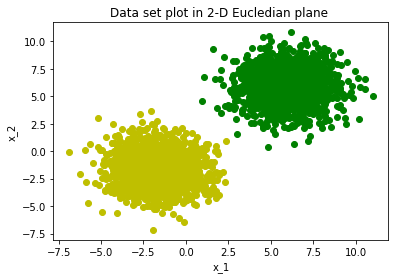

In [89]:
Xby=linear_seperable(-1.7,1.5,6,1.5,1500,linear_true_labels_1)
color_map={'1.0':'y','-1.0':'g'}
plot_data_and_hyperplane(Xby,color_map,1)

Plotting 2-D linearly seperable data with lower-bounds on seperability

6.0


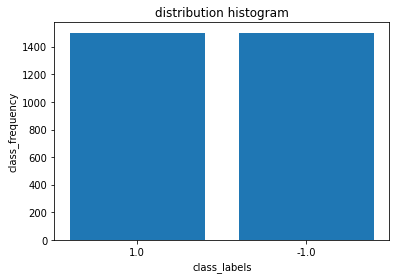

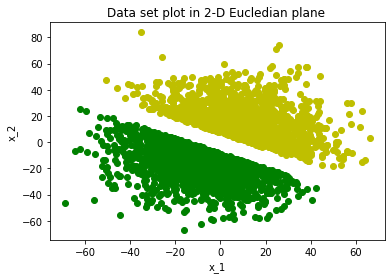

In [91]:
seperation=6.0
Xby_g,params_vector=linear_seperable_guarented(0,20,1,1,1500,seperation=seperation)
print(seperation)
color_map={'1.0':'y','-1.0':'g'}
plot_data_and_hyperplane(Xby_g,color_map,1)

Plotting 2-D non linearly seperable data : This data is sampled out from normal distributions in such a way that only its true_labels are non-linear. Thus it is not suitable for training a model(according to experiments).

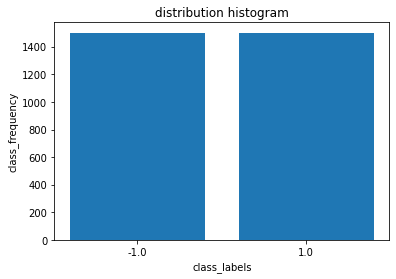

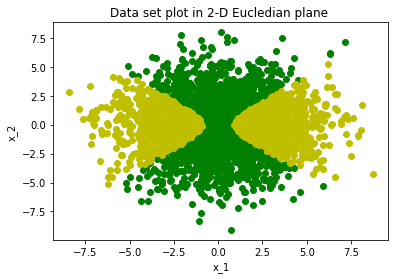

In [92]:
color_map={'1.0':'y','-1.0':'g'}
Xby_nl=non_linear_seperable(0,2.5,1,1.8,1500,non_linear_true_labels_1,"hyperbola")
# emperical set of best first 4 parametrs (mean1,std_dev1,mean2,std_dev2)
# circle : 0,1,0,1
# ellipse: 0,1,1,3
# parabola : 0,1.3,1,2.2
#hyperbola: 0,2.5,1,1.8

plot_data_and_hyperplane(Xby_nl,color_map,1)

Plotting 2-D Non linearly seperable circular data. This data is suitable for classification since data points sampled are distributed in cicular topology on 2-D space.

In [98]:
def circular_dataset(num_samples):
  np.random.seed(0)  
  Dimension = 2 # dimensionality
  classes = 2 # number of classes
  X = np.zeros((num_samples*classes,Dimension))
  y = np.zeros(num_samples*classes)
  radius=[5.0,10.0] # concentric circles
  class_labels=[-1.0,1.0]
  for j in range(classes):
    horizontal_axis = range(num_samples*j,num_samples*(j+1))    
    theta = np.linspace(0,np.pi*2.0,num_samples)
    for m in horizontal_axis:
      q=np.random.normal(0,0.5)
      X[m] = np.c_[radius[j]*np.sin(theta[m-j*num_samples])+q, radius[j]*np.cos(theta[m-j*num_samples])+q]
    y[horizontal_axis] = class_labels[j] # class labels
  bias=[1.0]*X.shape[0]
  Xb=np.c_[X,np.array(bias)]
  Xby=np.c_[Xb,y]
  #print(y)   
  return torch.from_numpy(Xby)  


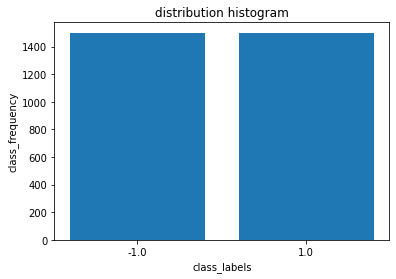

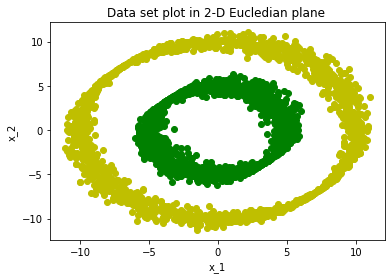

In [99]:
color_map={'1.0':'y','-1.0':'g'}
Xby_nl_c=circular_dataset(1500)
plot_data_and_hyperplane(Xby_nl_c,color_map,1)

Perceptron learning algo;

In [101]:
#perceptron learning rule
def perceptron_learn(Xby,bias,max_epochs,alpha,weights_intialization=0,decomposing_alpha=0):
  ''' Thsi function will take certain arguments as inputs and will train a single perceptron using sign activation fucntion and will output the weight vector.
  One thing to note is that in case of simple perceptrons bias is not learned and hence will be provided manually'''
  params_vector=torch.zeros((1,3)) # <w1,w2,b>
  params_vector[0,2]=bias
  if weights_intialization==1:
    w=torch.normal(-4,0.2,size=(1,2))
    params_vector[0,0]=w[0,0]
    params_vector[0,1]=w[0,1]
  data_rows,data_columns=Xby.shape[0],Xby.shape[1]
  train_data=Xby[:,0:-1]
  
  true_label=Xby[:,-1]
  sign=0 # '0' means not applicable
  alpha_list=[]
  if decomposing_alpha==1:
    for row in range(data_rows):
      alpha_list.append(1000/(1000+row))
  else:
    alpha_list=[alpha]*data_rows    
  
  total_changes_till_convergence=0
  epochs_till_convergence=0
  for e in range(max_epochs):
    total_changes_done_per_epoch=0
    for row in range(data_rows):
      
      if torch.dot(params_vector[0,:],train_data[row,:])*true_label[row]<=0: # this inequality has great effect of labels being choosed i.e beware of -1 & 0       
        # now we need to update the weights        
        params_vector[0,0]+=alpha_list[row]*true_label[row]*train_data[row,0]
        params_vector[0,1]+=alpha_list[row]*true_label[row]*train_data[row,1]
        total_changes_done_per_epoch+=1
    total_changes_till_convergence+=total_changes_done_per_epoch    
    epochs_till_convergence+=1
    if total_changes_done_per_epoch==0:
      # convergence has been achieved  
      print("Stopping before max_epochs : {} . Convergence achieved at {} epoch".format(max_epochs,epochs_till_convergence))
      break
   
  return (params_vector,total_changes_till_convergence,epochs_till_convergence)

Tarining single perceptron model using linear seperable data 

In [102]:
Xby_g,_=linear_seperable_guarented(0,20,1,1,1500,1.0)
params_vector,total_changes_till_convergence,epochs_till_convergence=perceptron_learn(Xby_g,1,50,0.5)

Stopping before max_epochs : 50 . Convergence achieved at 2 epoch


Plotting data and intial params vector <0.0,0.0,1.0>

{} exception has occured 


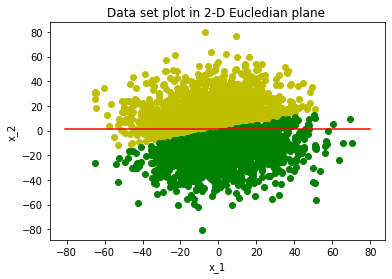

In [105]:
initial_params=torch.zeros(size=(1,3))
initial_params[0,2]=1.0
color_map={'1.0':'y','-1.0':'g'}
plot_data_and_hyperplane(Xby_g,color_map,params_vector=initial_params[0,:])

Plotting data & learnt hyperplane/classifier using perceptron learning.

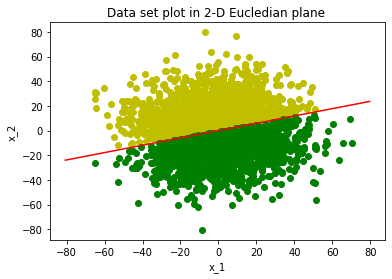

In [106]:
color_map={'1.0':'y','-1.0':'g'}
plot_data_and_hyperplane(Xby_g,color_map,params_vector=params_vector[0,:])

Experminets regarding K [No. of iterations/epochs required for perfect classification ] &  λ [Level of seperability].

************************************************************************** 
This experiment uses 5 levels of  λ --> ["very_high","high","medium","low","very_low"]. For Each level 2 type of linearly seperable 2-D datasets are taken
a) sepeartion on basis of setting mean only [hence only qualitative analysis]
b) sepration on basis of lower bounds over distanbce of a sampled 2-D data point from a randomly choosen hyperplane.
For each level 5 runs are done . In each run dataset id row-wise shuffled and geo-mean is reported with respect to K for each level. 
Finally a bar plot for both datasets comparing average K and λ is plotted

In [ ]:
# Experiment reagrding K (no. of iterations required for perfect classification) and level of sepereability (T) 

In [107]:
# using linrealy seperable data sampled from randomly sampling it from normal distribution 
KvsT={"very_high":[],"high":[],"medium":[],"low":[],"very_low":[]} # in the list we will hold the K with respect to 5 runs per category with random shuffling of dataset rows
# using linrealy seperable data sampled from randomly sampling it from normal distribution with a guarentee on seperation
KvsT_g={"very_high":{"seperation":0.1,"K":[]},"high":{"seperation":0.1,"K":[]},"medium":{"seperation":0.1,"K":[]},"low":{"seperation":0.1,"K":[]},"very_low":{"seperation":0.1,"K":[]}}

shape of final X is
torch.Size([3000, 2])
---------------- linearly seperable data -----------------------
---------------- linearly seperable data with guarented amount of seperation= 0.1-----------------------
Stopping before max_epochs : 500 . Convergence achieved at 241 epoch
Stopping before max_epochs : 500 . Convergence achieved at 203 epoch
Stopping before max_epochs : 500 . Convergence achieved at 313 epoch
Stopping before max_epochs : 500 . Convergence achieved at 73 epoch
Stopping before max_epochs : 500 . Convergence achieved at 5 epoch
Stopping before max_epochs : 500 . Convergence achieved at 2 epoch
Stopping before max_epochs : 500 . Convergence achieved at 7 epoch
Stopping before max_epochs : 500 . Convergence achieved at 2 epoch
Stopping before max_epochs : 500 . Convergence achieved at 4 epoch
Stopping before max_epochs : 500 . Convergence achieved at 2 epoch


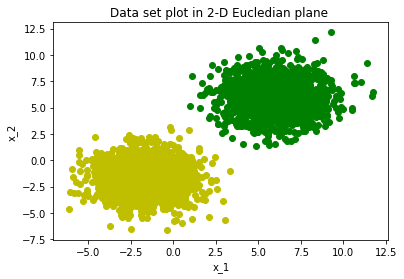

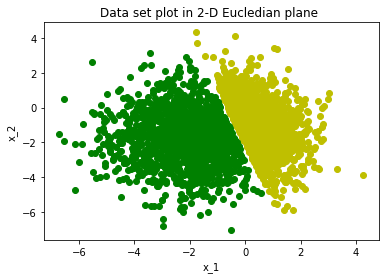

In [109]:
# for very_low seperability
KvsT["very_low"]=[]
KvsT_g["very_low"]["K"]=[]
seperation=0.1
KvsT_g["very_low"]["seperation"]=seperation
Xby1=linear_seperable(-1.7,1.5,6,1.5,1500,linear_true_labels_1)
Xby1_g,_=linear_seperable_guarented(-1.7,1.5,6,1.5,1500,seperation)
#print(Xby1_g)
color_map={'1.0':'y','-1.0':'g'}
print("---------------- linearly seperable data -----------------------")
plot_data_and_hyperplane(Xby1,color_map)
print("---------------- linearly seperable data with guarented amount of seperation= {}-----------------------".format(seperation))
plot_data_and_hyperplane(Xby1_g,color_map)

for run in range(5):
  Xby1=Xby1[torch.randperm(Xby1.size()[0])] # for each run do dataset shuffling
  params_vector,total_changes_till_convergence,epochs_till_convergence=perceptron_learn(Xby1,1,500,0.5)  
  KvsT["very_low"].append(epochs_till_convergence)
  
for run in range(5):
  Xby1_g=Xby1_g[torch.randperm(Xby1.size()[0])]
  params_vector_g,total_changes_till_convergence_g,epochs_till_convergence_g=perceptron_learn(Xby1_g,1,500,0.5)
  KvsT_g["very_low"]["K"].append(epochs_till_convergence_g)



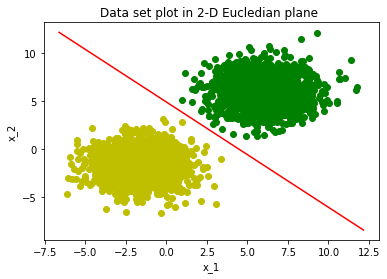

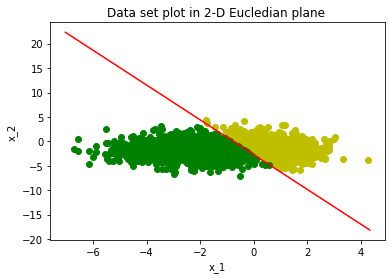

In [110]:
color_map={'1.0':'y','-1.0':'g'}
plot_data_and_hyperplane(Xby1,color_map,params_vector=params_vector[0,:])
plot_data_and_hyperplane(Xby1_g,color_map,params_vector=params_vector_g[0,:])


shape of final X is
torch.Size([3000, 2])
---------------- linearly seperable data -----------------------
---------------- linearly seperable data with guarented amount of seperation=0.3 -----------------------
Stopping before max_epochs : 500 . Convergence achieved at 17 epoch
Stopping before max_epochs : 500 . Convergence achieved at 8 epoch
Stopping before max_epochs : 500 . Convergence achieved at 3 epoch
Stopping before max_epochs : 500 . Convergence achieved at 5 epoch
Stopping before max_epochs : 500 . Convergence achieved at 4 epoch
Stopping before max_epochs : 500 . Convergence achieved at 3 epoch
Stopping before max_epochs : 500 . Convergence achieved at 2 epoch
Stopping before max_epochs : 500 . Convergence achieved at 2 epoch
Stopping before max_epochs : 500 . Convergence achieved at 2 epoch
Stopping before max_epochs : 500 . Convergence achieved at 2 epoch


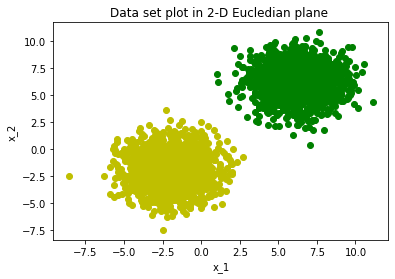

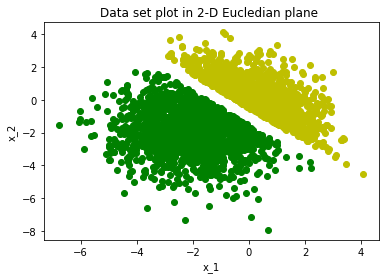

In [112]:
# for low seperability
KvsT["low"]=[]
KvsT_g["low"]["K"]=[]
Xby2=linear_seperable(-2,1.5,6.2,1.5,1500,linear_true_labels_1)
seperation=0.3
Xby2_g,_=linear_seperable_guarented(-1.7,1.5,6,1.5,1500,seperation)
KvsT_g["low"]["seperation"]=seperation
#print(Xby1_g)
color_map={'1.0':'y','-1.0':'g'}
print("---------------- linearly seperable data -----------------------")
plot_data_and_hyperplane(Xby2,color_map)
print("---------------- linearly seperable data with guarented amount of seperation={} -----------------------".format(seperation))
plot_data_and_hyperplane(Xby2_g,color_map)

for run in range(5):
  Xby2=Xby2[torch.randperm(Xby2.size()[0])] # for each run do dataset shuffling  
  params_vector,total_changes_till_convergence,epochs_till_convergence=perceptron_learn(Xby2,1,500,0.5)  
  KvsT["low"].append(epochs_till_convergence)
  

for run in range(5):
  Xby2_g=Xby2_g[torch.randperm(Xby2_g.size()[0])] # for each run do dataset shuffling
  params_vector_g,total_changes_till_convergence_g,epochs_till_convergence_g=perceptron_learn(Xby2_g,1,500,0.5)
  KvsT_g["low"]["K"].append(epochs_till_convergence_g)  




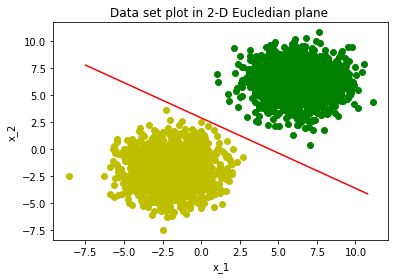

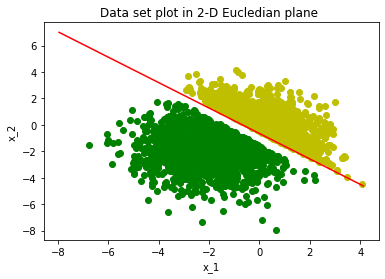

In [113]:
color_map={'1.0':'y','-1.0':'g'}
plot_data_and_hyperplane(Xby2,color_map,params_vector=params_vector[0,:])
plot_data_and_hyperplane(Xby2_g,color_map,params_vector=params_vector_g[0,:])

shape of final X is
torch.Size([3000, 2])
---------------- linearly seperable data -----------------------
---------------- linearly seperable data with guarented amount of seperation=1 -----------------------
Stopping before max_epochs : 500 . Convergence achieved at 7 epoch
Stopping before max_epochs : 500 . Convergence achieved at 9 epoch
Stopping before max_epochs : 500 . Convergence achieved at 6 epoch
Stopping before max_epochs : 500 . Convergence achieved at 5 epoch
Stopping before max_epochs : 500 . Convergence achieved at 6 epoch
Stopping before max_epochs : 500 . Convergence achieved at 2 epoch
Stopping before max_epochs : 500 . Convergence achieved at 2 epoch
Stopping before max_epochs : 500 . Convergence achieved at 2 epoch
Stopping before max_epochs : 500 . Convergence achieved at 2 epoch
Stopping before max_epochs : 500 . Convergence achieved at 2 epoch


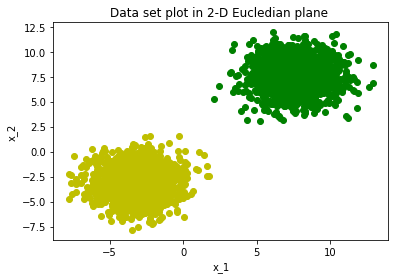

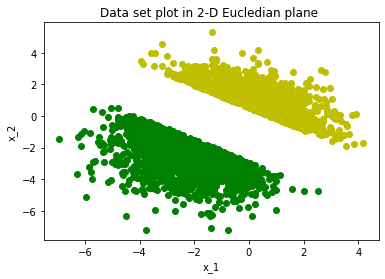

In [127]:
# for medium seperability
KvsT["medium"]=[]
KvsT_g["medium"]["K"]=[]
seperation=1
KvsT_g["medium"]["seperation"]=seperation
Xby3=linear_seperable(-3.1,1.5,7.5,1.5,1500,linear_true_labels_1)
Xby3_g,_=linear_seperable_guarented(-1.7,1.5,6,1.5,1500,seperation)
#print(Xby1_g)
color_map={'1.0':'y','-1.0':'g'}
print("---------------- linearly seperable data -----------------------")
plot_data_and_hyperplane(Xby3,color_map)
print("---------------- linearly seperable data with guarented amount of seperation={} -----------------------".format(seperation))
plot_data_and_hyperplane(Xby3_g,color_map)

for run in range(5):
  Xby3=Xby3[torch.randperm(Xby3.size()[0])] # for each run do dataset shuffling
  params_vector,total_changes_till_convergence,epochs_till_convergence=perceptron_learn(Xby3,1,500,0.5) 
  KvsT["medium"].append(epochs_till_convergence)
  
for run in range(5):
   Xby3=Xby3[torch.randperm(Xby3.size()[0])] # for each run do dataset shuffling 
   params_vector_g,total_changes_till_convergence_g,epochs_till_convergence_g=perceptron_learn(Xby3_g,1,500,0.5)
   KvsT_g["medium"]["K"].append(epochs_till_convergence_g)



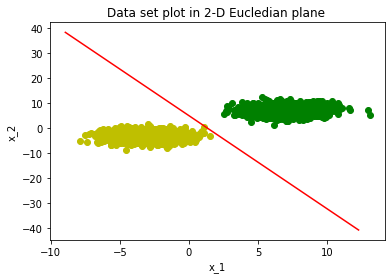

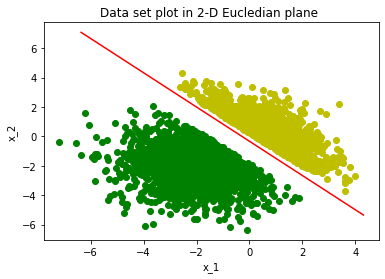

In [115]:
color_map={'1.0':'y','-1.0':'g'}
plot_data_and_hyperplane(Xby3,color_map,params_vector=params_vector[0,:])
plot_data_and_hyperplane(Xby3_g,color_map,params_vector=params_vector_g[0,:])

shape of final X is
torch.Size([3000, 2])
---------------- linearly seperable data -----------------------
---------------- linearly seperable data with guarented amount of seperation=1.8 -----------------------
Stopping before max_epochs : 500 . Convergence achieved at 2 epoch
Stopping before max_epochs : 500 . Convergence achieved at 2 epoch
Stopping before max_epochs : 500 . Convergence achieved at 2 epoch
Stopping before max_epochs : 500 . Convergence achieved at 2 epoch
Stopping before max_epochs : 500 . Convergence achieved at 2 epoch
Stopping before max_epochs : 500 . Convergence achieved at 2 epoch
Stopping before max_epochs : 500 . Convergence achieved at 2 epoch
Stopping before max_epochs : 500 . Convergence achieved at 2 epoch
Stopping before max_epochs : 500 . Convergence achieved at 2 epoch
Stopping before max_epochs : 500 . Convergence achieved at 2 epoch


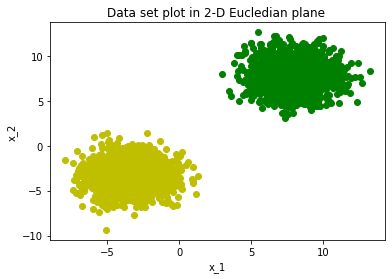

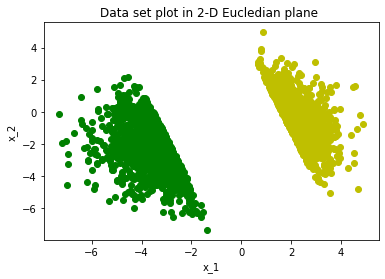

In [116]:
# for high seperability
KvsT["high"]=[]
KvsT_g["high"]["K"]=[]
seperation=1.8
KvsT_g["high"]["seperation"]=seperation
Xby4=linear_seperable(-3.3,1.5,7.9,1.5,1500,linear_true_labels_1)
Xby4_g,_=linear_seperable_guarented(-1.7,1.5,6,1.5,1500,seperation)
#print(Xby1_g)
color_map={'1.0':'y','-1.0':'g'}
print("---------------- linearly seperable data -----------------------")
plot_data_and_hyperplane(Xby4,color_map)
print("---------------- linearly seperable data with guarented amount of seperation={} -----------------------".format(seperation))
plot_data_and_hyperplane(Xby4_g,color_map)

for run in range(5):
  Xby4=Xby4[torch.randperm(Xby4.size()[0])] # for each run do dataset shuffling
  params_vector,total_changes_till_convergence,epochs_till_convergence=perceptron_learn(Xby4,1,500,0.5)  
  KvsT["high"].append(epochs_till_convergence)
  
for run in range(5):
  Xby4_g=Xby4_g[torch.randperm(Xby4_g.size()[0])] # for each run do dataset shuffling
  params_vector_g,total_changes_till_convergence_g,epochs_till_convergence_g=perceptron_learn(Xby4_g,1,500,0.5)
  KvsT_g["high"]["K"].append(epochs_till_convergence_g)





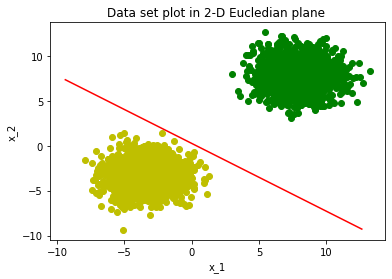

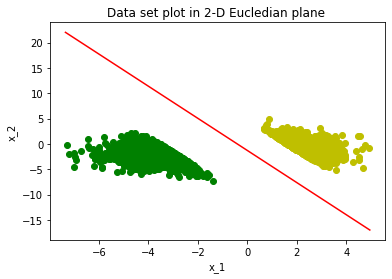

In [117]:
color_map={'1.0':'y','-1.0':'g'}
plot_data_and_hyperplane(Xby4,color_map,params_vector=params_vector[0,:])
plot_data_and_hyperplane(Xby4_g,color_map,params_vector=params_vector_g[0,:])

shape of final X is
torch.Size([3000, 2])
---------------- linearly seperable data -----------------------
---------------- linearly seperable data with guarented amount of seperation= 2.4 -----------------------
Stopping before max_epochs : 500 . Convergence achieved at 2 epoch
Stopping before max_epochs : 500 . Convergence achieved at 2 epoch
Stopping before max_epochs : 500 . Convergence achieved at 2 epoch
Stopping before max_epochs : 500 . Convergence achieved at 2 epoch
Stopping before max_epochs : 500 . Convergence achieved at 2 epoch
Stopping before max_epochs : 500 . Convergence achieved at 2 epoch
Stopping before max_epochs : 500 . Convergence achieved at 2 epoch
Stopping before max_epochs : 500 . Convergence achieved at 2 epoch
Stopping before max_epochs : 500 . Convergence achieved at 2 epoch
Stopping before max_epochs : 500 . Convergence achieved at 2 epoch


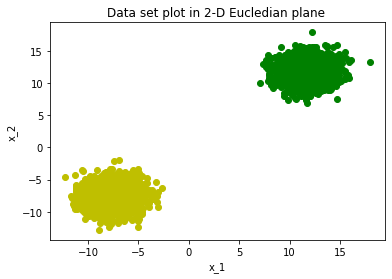

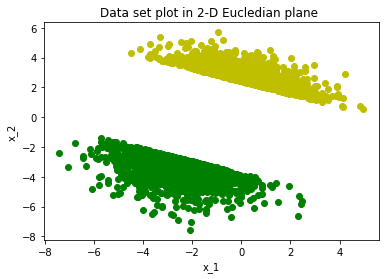

In [118]:
# for very-high seperability
KvsT["very_high"]=[]
KvsT_g["very_high"]["K"]=[]
seperation=2.4
KvsT_g["very_high"]["seperation"]=seperation
Xby5=linear_seperable(-7.5,1.5,11.8,1.5,1500,linear_true_labels_1)
Xby5_g,_=linear_seperable_guarented(-1.7,1.5,6,1.5,1500,seperation)
#print(Xby1_g)
color_map={'1.0':'y','-1.0':'g'}
print("---------------- linearly seperable data -----------------------")
plot_data_and_hyperplane(Xby5,color_map)
print("---------------- linearly seperable data with guarented amount of seperation= {} -----------------------".format(seperation))
plot_data_and_hyperplane(Xby5_g,color_map)

for run in range(5):
  Xby5=Xby5[torch.randperm(Xby5.size()[0])] # for each run do dataset shuffling
  params_vector,total_changes_till_convergence,epochs_till_convergence=perceptron_learn(Xby5,1,500,0.5) 
  KvsT["very_high"].append(epochs_till_convergence)
  

for run in range(5):
   Xby5_g=Xby5_g[torch.randperm(Xby5_g.size()[0])] # for each run do dataset shuffling
   params_vector_g,total_changes_till_convergence_g,epochs_till_convergence_g=perceptron_learn(Xby5_g,1,500,0.5)
   KvsT_g["very_high"]["K"].append(epochs_till_convergence_g)



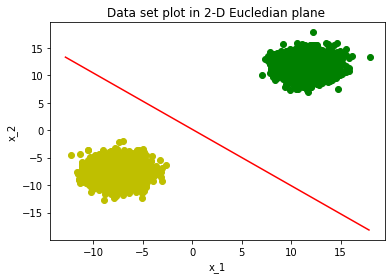

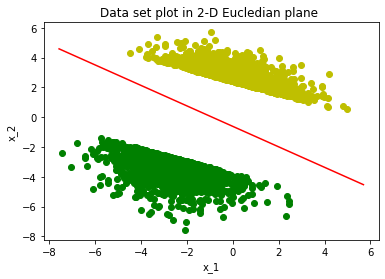

In [119]:
color_map={'1.0':'y','-1.0':'g'}
plot_data_and_hyperplane(Xby5,color_map,params_vector=params_vector[0,:])
plot_data_and_hyperplane(Xby5_g,color_map,params_vector=params_vector_g[0,:])

In [ ]:
KvsT

In [ ]:
KvsT_g

Below are the bar plots for teh above experiment.

Text(0.5, 1.0, 'perfect classfication vs level of seperability')

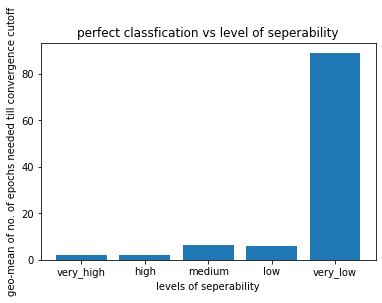

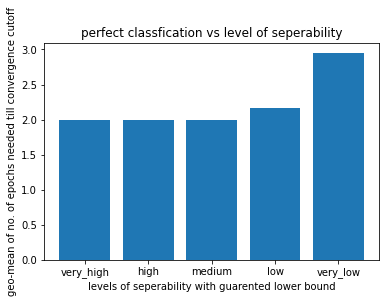

In [130]:
fig,axis=plt.subplots()
geo_mean_epochs_per_category=[]
geo_mean_epochs_per_category_g=[]
for key in KvsT.keys():
  prod=1
  prod_g=1
  for val in KvsT[key]:
     prod*=val
  for val in KvsT_g[key]["K"]:
    prod_g*=val

  geo_mean_epochs_per_category.append(prod ** (1./5.))
  geo_mean_epochs_per_category_g.append(prod_g ** (1./5.))

#print(KvsT.keys())
#print(geo_mean_epochs_per_category)

axis.bar(KvsT.keys(),geo_mean_epochs_per_category)
axis.set_xlabel("levels of seperability")
axis.set_ylabel("geo-mean of no. of epochs needed till convergence cutoff")
axis.set_title("perfect classfication vs level of seperability")

fig,axis=plt.subplots()
axis.bar(KvsT.keys(),geo_mean_epochs_per_category_g)
axis.set_xlabel("levels of seperability with guarented lower bound")
axis.set_ylabel("geo-mean of no. of epochs needed till convergence cutoff")
axis.set_title("perfect classfication vs level of seperability")


In [131]:
# as can be seen from above graph the no. of iteration K w.r.t level of seperability is increasing non-linearly

Q2) Consider solving the above problem (training a line for classifying a linearly separable 2D dataset) using Gradient Descent algorithm. Think of a loss function (beyond simple MSE) based on our classroom discussion on the desirable properties of a loss function. You may implement the analytical way of finding gradient for it. You may implement the basic version of gradient descent update equation. Plot the dataset before and after training (with the classifier).

In [132]:
def pre_activation_derivative_weights(X,row,weight_index):
  return X[row,weight_index]
def pre_activation_derivative_weights():
  return 1   

Below few cells implemnt 3 activation function along with there respective derivative  -->

  1)sigmoid

  2)relu
  
  3)leaky relu(alph=0.001)

In [142]:
# sigmoid activation
def sigmoid_activation(pre_activation, alpha=0):   
  return 1.0 / (1.0 + np.exp(-1.0*pre_activation))

def sigmoid_derivative(pre_activation,X,row,weight_index,alpha=0,wrt_bias=0):
  activation=sigmoid_activation(pre_activation)
  q=X[row,weight_index]
  if wrt_bias==1:
    q=1.0
  return activation * (1.0 - activation)*q

In [143]:
# Relu activation
def relu_activation(pre_activation, alpha=0):
    return np.maximum(0, pre_activation)

def relu_derivative(pre_activation,X,row,weight_index,alpha=0,wrt_bias=0):
    if pre_activation<=0:# sub-gradient
      return 0       
    elif wrt_bias==1:
      return 1
    else:
      return X[row,weight_index]


In [144]:
# leaky relu
def leaky_relu_activation(pre_activation, alpha=0.01):
    return np.maximum(alpha*pre_activation, pre_activation)

def leaky_relu_derivative(pre_activation,X,row,weight_index,alpha=0.01,wrt_bias=0):
    if pre_activation<=0:# sub-gradient
      return alpha 
    elif wrt_bias==1:
      return 1        
    else:
      return X[row,weight_index]


Below cell implement Binary Cross Entropy loss along with its derivative . Since we only have one neuron for Q2 so no necessasity to use softmax activation for output neuron 

In [135]:
def binary_cross_entropy_loss1(y_pred, y_true):
  ## BEWARE THAT Y_TRUE IS NOT PROBABILITY OF Y_TRUE ; IT'S THE CLASS LABEL    
    if y_true.item()==-1.0:
      loss1=torch.as_tensor(0.0,dtype=torch.float64)
    else:
      p_y_true_being_class1=torch.as_tensor(1.0,dtype=torch.float64)      
      loss1= p_y_true_being_class1 * np.log(y_pred+epsilon)
    if y_true.item()==1.0:
      loss2=torch.as_tensor(0.0,dtype=torch.float64)
    else:
      p_y_true_being_not_class1=torch.as_tensor(1.0,dtype=torch.float64)      
      loss2= p_y_true_being_not_class1 * np.log(1.0-y_pred+epsilon)      
    loss= -1.0*(loss1+loss2)    
    return loss

def binary_cross_entropy_derivative1(y_pred, y_true):
  ## BEWARE THAT Y_TRUE IS NOT PROBABILITY OF Y_TRUE ; IT'S THE CLASS LABEL
    if y_true.item()==-1.0:
      part1=torch.as_tensor(0.0,dtype=torch.float64)
    else:
      p_y_true_being_class1=torch.as_tensor(1.0,dtype=torch.float64)      
      part1= -(p_y_true_being_class1/(y_pred+epsilon))
    if y_true.item()==1.0:
      part2=torch.as_tensor(0.0,dtype=torch.float64)
    else:
      p_y_true_being_not_class1=torch.as_tensor(1.0,dtype=torch.float64)      
      part2= ((p_y_true_being_not_class1)/(1.0-y_pred+epsilon))
        
    return  part2-part1 


Forward Pass for one neuron network

In [136]:
# forward pass
def forward_pass(data_row,params_vector):
  return torch.dot(data_row,params_vector[0,:])

Gradient Descent algo for one neuron network using many options which can be set to observe different performance aspects. This gradient descent function works for Non-tensor/array weights. 

In [161]:
def gradient_descent(Xby,loss_function,activation_function,loss_function_derivative,activation_function_derivative,param_mean,param_stddev,max_epochs,learning_rate,param_updation_tolerance=0.0001):
  params_vector=torch.normal(param_mean,param_stddev,size=(1,3))
  initial_params_vector=torch.clone(params_vector)  
  data_rows,data_columns=Xby.shape[0],Xby.shape[1]
  train_data=Xby[:,0:-1]  
  true_label=Xby[:,-1]
  total_loss_per_epoch=[0.0]
  epochs_used=0
  param_vector_per_epoch=[]
  for e in range(max_epochs):
    total_loss_derivative=[0]*3
    total_loss=0    
    for row in range(data_rows):
      # forward pass      
      pre_activation=forward_pass(train_data[row,:],params_vector)      
      predicted=activation_function(pre_activation)      
      total_loss+=loss_function(predicted,true_label[row])
      total_loss_derivative[0]+=loss_function_derivative(predicted,true_label[row])*activation_function_derivative(pre_activation,train_data,row,0)
      total_loss_derivative[1]+=loss_function_derivative(predicted,true_label[row])*activation_function_derivative(pre_activation,train_data,row,1)
      total_loss_derivative[2]+=loss_function_derivative(predicted,true_label[row])*activation_function_derivative(pre_activation,train_data,row,2,1)# gradient with respect to bias
    # after completing 1 epoch all teh parametrs will be updated
    
    updation_vector=torch.tensor([total_loss_derivative[0],total_loss_derivative[1],total_loss_derivative[2]]).reshape(1,3)
    for i in range(updation_vector.shape[1]):
      updation_vector[0,i]*=(learning_rate/data_rows) # should divide by no. of samples ??
    
    tolerance_bool= torch.abs(updation_vector[0,:]) < torch.as_tensor(param_updation_tolerance,dtype=torch.float64)  
    total_loss/=data_rows
    if torch.abs(total_loss-total_loss_per_epoch[-1])< 0.000001: # there is not much change in parameters
      print(" convergnce achieved before max epochs {} . total epochs used {}".format(max_epochs,epochs_used))
      break
    else:
      params_vector[0,0]+=  -1.0*updation_vector[0,0]
      params_vector[0,1]+=  -1.0*updation_vector[0,1]
      params_vector[0,2]+=  -1.0*updation_vector[0,2]
      #print(params_vector)      
      param_vector_per_epoch.append(torch.clone(params_vector))
      print("total loss after epoch {}".format(e))
      print(total_loss)
      total_loss_per_epoch.append(total_loss)
      epochs_used+=1 
    
    
  return (params_vector,total_loss_per_epoch,param_vector_per_epoch,initial_params_vector) 








Generating a new 2-D linear dataset for training gradient descent algo.  

In [140]:
Xby=linear_seperable(-4,1.5,8,1.5,1500,linear_true_labels_1)

shape of final X is
torch.Size([3000, 2])


Training gradient descent model.

In [157]:
params_vector,total_loss_per_epoch,param_vector_per_epoch,initial_params_vector=gradient_descent(Xby,binary_cross_entropy_loss1,sigmoid_activation,binary_cross_entropy_derivative1,sigmoid_derivative,0,1,20,0.01,0.001)

tensor([[-0.3468,  0.2803,  0.8649]])
total loss after epoch 0
tensor(0.7388, dtype=torch.float64)
tensor([[-0.3642,  0.2626,  0.8608]])
total loss after epoch 1
tensor(0.6206, dtype=torch.float64)
tensor([[-0.3794,  0.2469,  0.8571]])
total loss after epoch 2
tensor(0.5271, dtype=torch.float64)
tensor([[-0.3928,  0.2331,  0.8537]])
total loss after epoch 3
tensor(0.4538, dtype=torch.float64)
tensor([[-0.4045,  0.2209,  0.8507]])
total loss after epoch 4
tensor(0.3963, dtype=torch.float64)
tensor([[-0.4148,  0.2100,  0.8479]])
total loss after epoch 5
tensor(0.3507, dtype=torch.float64)
tensor([[-0.4240,  0.2004,  0.8454]])
total loss after epoch 6
tensor(0.3142, dtype=torch.float64)
tensor([[-0.4322,  0.1917,  0.8431]])
total loss after epoch 7
tensor(0.2846, dtype=torch.float64)
tensor([[-0.4396,  0.1839,  0.8409]])
total loss after epoch 8
tensor(0.2603, dtype=torch.float64)
tensor([[-0.4463,  0.1768,  0.8389]])
total loss after epoch 9
tensor(0.2401, dtype=torch.float64)
tensor([[-

In above output trace a continosly decreasing loss can be seen . Plotting The same also.

Text(0, 0.5, 'total_loss')

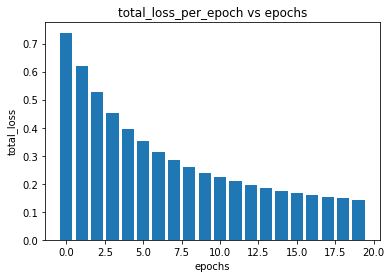

In [162]:
fig,ax=plt.subplots()
ax.bar(range(len(total_loss_per_epoch)-1),total_loss_per_epoch[1:])
ax.set_title("total_loss_per_epoch vs epochs")
ax.set_xlabel("epochs")
ax.set_ylabel("total_loss")

Plotting data & initial random hyperplane

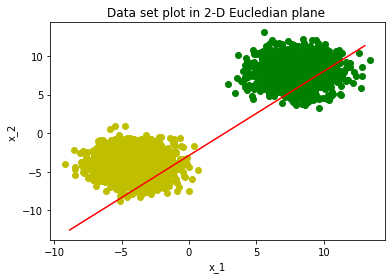

In [159]:
color_map={'1.0':'y','-1.0':'g'}
plot_data_and_hyperplane(Xby,color_map,params_vector=initial_params_vector[0,:])

Plotting learnt hyperplane 

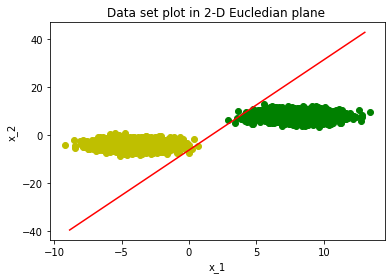

In [160]:
color_map={'1.0':'y','-1.0':'g'}
plot_data_and_hyperplane(Xby,color_map,params_vector=params_vector[0,:])

Q3) Consider a binary classification dataset that is not linearly separable in 2D (e.g. data lying on the circumference two concentric circles). Train a Multi layer perceptron (MLP) with a single hidden layer for classifying the same. You may use the loss function used in problem 2. You have to implement the gradient descent (i.e. backpropagation) algorithm yourself.

In [172]:
def tensor_forward_pass(previous_layer_output,current_layer_weight_tensor,current_layer_bias_tensor):  
  a=torch.sum(torch.matmul(current_layer_weight_tensor.T,previous_layer_output.reshape(previous_layer_output.shape[0],1)),dim=1).reshape(current_layer_weight_tensor.shape[1],1)  
  preactivation= a+current_layer_bias_tensor  
  return preactivation

Above is the forward pass function able to handle tensors  

In [173]:
def tensor_layer_activation(preactivation,activation_function):
  no_of_neurons=preactivation.shape[0]
  activated=torch.zeros(size=(no_of_neurons,1))
  for neuron in range(no_of_neurons):
    activated[neuron,0]=activation_function(preactivation[neuron])
  return activated  

Above is teh general fucntion which will calculate element-wise activation from each neuron's preactivation in a given layer.

In [171]:
def xavier_intialization(layer_fan_in,layer_fan_out):
  return torch.ones(size=(layer_fan_in,layer_fan_out)).uniform_(-1,1)*math.sqrt(6.0/(layer_fan_in+layer_fan_out))


Above is the implemengtation of xavier initilization used to intialize all the parameters.

In [178]:
# activation function derivatives with repect to preactivation
def sigmoid_activation_wrt_preactivation(pre_activation,alpha=0.01):
  a=sigmoid_activation(pre_activation)
  return a*(1.0-a)

def relu_activation_wrt_preactivation(pre_activation,alpha=0.01):
  grad=torch.zeros(size=pre_activation.shape)
  grad[pre_activation<=0.0]=0.0
  grad[pre_activation>0.0]=1.0
  return grad
  
def leaky_relu_activation_wrt_preactivation(pre_activation,alpha=0.01):
  grad=torch.zeros(size=pre_activation.shape)
  grad[pre_activation<=0.0]=alpha
  grad[pre_activation>0.0]=1.0
  return grad

Above are the functions to handle tensors and give gradient/derivative of corresponding activation function

In [179]:
def tensor_gradient_descent(Xby_nl,W1,W2,B1,B2,activation_function_hidden_layer,output_activation_function,loss_function,loss_function_derivative,output_activation_function_derivative,hidden_layer_activation_function_derivative,max_epochs,learning_rate,parameter_updation_tolerance=0.0099):
  data_rows,data_columns=Xby_nl.shape[0],Xby_nl.shape[1]
  true_labels=Xby_nl[:,-1]
  total_loss_per_epoch=[0]
  accuracy_per_epoch=[]
  epochs_used=0
  prediction=[]

  for e in range(max_epochs):    
    total_loss=0
    # data structures to accumultae changes for each parameter
    loss_gradient_W2=torch.zeros(size=(W2.shape[0],1))
    loss_gradient_W1=torch.zeros(size=(W1.shape[0],W1.shape[1]))
    loss_gradient_B2=torch.zeros(size=(B2.shape[0],1))
    loss_gradient_B1=torch.zeros(size=(B1.shape[0],1))
    
    prediction=[]
    for row in range(data_rows):
      # forward pass      
      preactivation1=tensor_forward_pass(Xby_nl[row,0:-2],W1,B1)
      
      activation1=tensor_layer_activation(preactivation1,activation_function_hidden_layer)
      
      preactivation2=tensor_forward_pass(activation1,W2,B2)
      
      activation2=tensor_layer_activation(preactivation2,output_activation_function) # predicted
      
      prediction.append(torch.clone(activation2)) # need to do thresholding to get accuracy
      
      loss=loss_function(activation2,true_labels[row])
      
      total_loss+=loss.item()

      # -------------------------------------------------------------------------- backprop ------------------------------------------------------------------------------
      
      
      # collecting gradient for W2 
            
      output_layer_chained_gradients=loss_function_derivative(activation2,true_labels[row])*output_activation_function_derivative(preactivation2) #.
      
      for weight in range(loss_gradient_W2.shape[0]):        
        loss_gradient_W2[weight,0]+=output_layer_chained_gradients[0,0]*activation1[weight,0]*learning_rate # last value will be output at that hidden layer neuron #.
      

      # collecting gradient for B2
      for bias in range(loss_gradient_B2.shape[0]):
        loss_gradient_B2[bias,0]+=output_layer_chained_gradients[0,0]*1.0*learning_rate #this 1.0 could be -1.0 also ? #.
      

      output_layer_gradient_wrt_hidden_layer_output=torch.zeros(size=(W2.shape[0],1))
      
      for hidden_neuron in range(W2.shape[0]):
        output_layer_gradient_wrt_hidden_layer_output[hidden_neuron,0]=output_layer_chained_gradients*W2[hidden_neuron,0] #.

      hidden_layer_gradient_wrt_hidden_layer_preactivation=torch.zeros(size=(W2.shape[0],1))
      
      for hidden_neuron in range(W2.shape[0]):
        hidden_layer_gradient_wrt_hidden_layer_preactivation[hidden_neuron,0]=output_layer_gradient_wrt_hidden_layer_output[hidden_neuron,0]*hidden_layer_activation_function_derivative(preactivation1)[hidden_neuron,0]#.
      
      #collecting gradients for W1
      for each_input in range(loss_gradient_W1.shape[0]):
        for hidden_weight in range(loss_gradient_W1.shape[1]):          
          loss_gradient_W1[each_input,hidden_weight]+=hidden_layer_gradient_wrt_hidden_layer_preactivation[hidden_weight,0]*Xby_nl[row,each_input]*learning_rate #?
      
      #collecting gradients for B1
      for hidden_bias in range(loss_gradient_B1.shape[0]):
        loss_gradient_B1[hidden_bias,0]+=hidden_layer_gradient_wrt_hidden_layer_preactivation[hidden_weight,0]*1.0*learning_rate #this 1.0 could be -1.0 also ?

      #checking for convergence
    
    convergence_cond1=abs(total_loss-total_loss_per_epoch[-1])<0.0001
    #convergence_cond2=(torch.all(torch.all(loss_gradient_W2<parameter_updation_tolerance)==True) and torch.all(torch.all(loss_gradient_W1<parameter_updation_tolerance)==True) and torch.all(torch.all(loss_gradient_B2<parameter_updation_tolerance)==True) and torch.all(torch.all(loss_gradient_B1<parameter_updation_tolerance)==True))
    
    
    if convergence_cond1:
      print(" convergnce achieved before max epochs {} . total epochs used {}".format(max_epochs,e))
      break      
    

    loss_gradient_W2=loss_gradient_W2/data_rows
    loss_gradient_B2=loss_gradient_B2/data_rows
    loss_gradient_W1=loss_gradient_W1/data_rows
    loss_gradient_B1=loss_gradient_B1/data_rows

    #update all the parametrs
    # updating W2
    for weight in range(W2.shape[0]):
      W2[weight,0]+=-1.0*loss_gradient_W2[weight,0]
    #updating B2
    for bias in range(B2.shape[0]):
      B2[bias,0]+=-1.0*loss_gradient_B2[bias,0]
    #updating W1
    for each_input in range(W1.shape[0]):
      for hidden_weight in range(W1.shape[1]):
        W1[each_input,hidden_weight]+=-1.0*loss_gradient_W1[each_input,hidden_weight]
    #updating B1
    for hidden_bias in range(B1.shape[0]):
      B1[hidden_bias,0]+=-1.0*loss_gradient_B1[hidden_bias,0]
    
    avg_total_loss=total_loss/data_rows
    print("------------------------------------------------------------------------- epoch : {} ----------------------------------------------------------------------".format(epochs_used))
    print("total loss after epoch {} is ".format(avg_total_loss))
    total_loss_per_epoch.append(avg_total_loss)   
    
    # calculating accuracy
    correct_classification_count=0    
    for rows in range(data_rows):      
      if prediction[rows][0,0]>=0.50 and true_labels[rows]==1.0:
        correct_classification_count+=1          
      elif prediction[rows][0,0]<0.50 and true_labels[rows]==-1.0:
        correct_classification_count+=1         
    accuracy_per_epoch.append(100*(correct_classification_count/data_rows))
    print("accuracy after epoch {} is ".format(accuracy_per_epoch[-1]))      

    epochs_used+=1

  return(total_loss_per_epoch[1:],accuracy_per_epoch,epochs_used,W1,W2,B1,B2,prediction)


Above is the tensor capable gradient descent employing self-explanatory backpropogation and forward pass. It has many options to tweak and study performance measures . A MAJOR ASSUMPTION IS THAT THE NETWORK IS A SINGLE HIDDEN LAYER MLP WITH ONE NEURON IN OUTPUT LAYER.

In order to minimize any redundant caculation in case of parameter updation multiplcations are once done and presereved such that they can be used further updating hidden layers

In [191]:
# this mlp network contains one hidden layer only and one neuron in ouput layer
def MLP(Xby_nl,neurons_in_hidden_layer,activation_function_hidden_layer,output_activation_function,loss_function,loss_function_derivative,output_activation_function_derivative,hidden_layer_activation_function_derivative,max_epochs,learning_rate):
  
  data_rows,data_columns=Xby_nl.shape[0],Xby_nl.shape[1]  
  W1=torch.zeros(size=(data_columns-2,neurons_in_hidden_layer))
  W2=torch.zeros(size=(neurons_in_hidden_layer,1))
  B1=torch.zeros(size=(neurons_in_hidden_layer,1))
  B2=torch.zeros(size=(1,1))
    # randomly intialize above values
  W1=xavier_intialization(data_columns-2,neurons_in_hidden_layer)
  W2=xavier_intialization(neurons_in_hidden_layer,1)
  B1=xavier_intialization(neurons_in_hidden_layer,1)
  B2=xavier_intialization(1,1)
  return tensor_gradient_descent(Xby_nl,W1,W2,B1,B2,activation_function_hidden_layer,output_activation_function,loss_function,loss_function_derivative,output_activation_function_derivative,hidden_layer_activation_function_derivative,max_epochs,learning_rate)
  


Above is the driver code for tensor_gradient_descent.

In [184]:
Xby_nl_c=circular_dataset(1000)

Above generating a new circular data-set

In [185]:
Xby_nl_c.shape

torch.Size([2000, 4])

In [190]:
total_loss_per_epoch,accuracy_per_epoch,epochs_used,W1,W2,B1,B2,prediction=MLP(Xby_nl_c.float(),10,relu_activation,sigmoid_activation,binary_cross_entropy_loss1,binary_cross_entropy_derivative1,sigmoid_activation_wrt_preactivation,relu_activation_wrt_preactivation,20,0.1)

------------------------------------------------------------------------- epoch : 0 ----------------------------------------------------------------------
total loss after epoch 6.227966592788738 is 
accuracy after epoch 48.8 is 
------------------------------------------------------------------------- epoch : 1 ----------------------------------------------------------------------
total loss after epoch 7.306567330629749 is 
accuracy after epoch 49.75 is 
------------------------------------------------------------------------- epoch : 2 ----------------------------------------------------------------------
total loss after epoch 6.794965299785076 is 
accuracy after epoch 48.699999999999996 is 
------------------------------------------------------------------------- epoch : 3 ----------------------------------------------------------------------
total loss after epoch 6.391221124556731 is 
accuracy after epoch 48.75 is 
----------------------------------------------------------------

Text(0, 0.5, 'total_loss')

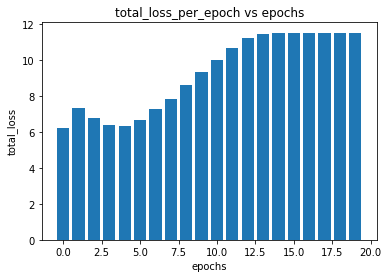

In [192]:
# plotting loss_per_epoch vs epochs
fig,ax=plt.subplots()
ax.bar(range(len(total_loss_per_epoch)),total_loss_per_epoch)
ax.set_title("total_loss_per_epoch vs epochs")
ax.set_xlabel("epochs")
ax.set_ylabel("total_loss")

Above plot is for loss per epoch 

Text(0, 0.5, 'classification accuracy per epoch')

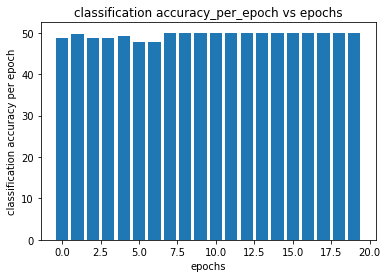

In [193]:
# plotting accuracy_per_epoch vs epochs
fig,ax=plt.subplots()
ax.bar(range(len(accuracy_per_epoch)),accuracy_per_epoch)
ax.set_title("classification accuracy_per_epoch vs epochs")
ax.set_xlabel("epochs")
ax.set_ylabel("classification accuracy per epoch")

Above plot is for accuracy per epoch.